#</br> Large Movie Review Dataset Sentiment Analysis </br>

Here we seek to investigate and compare the performances of three machine learning models in binary sentiment analysis tasks.

This notebook was primarily used to generate the outputs for the accompanying report, so please enjoy the (much cleaner) Sentiment_Analysis_Investigation.pdf report for a comprehensive review of the project.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer #bow
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)
from wordcloud import WordCloud
import re
from PIL import Image, ImageOps

In [ ]:
#Loading the dataset
df=pd.read_csv("/content/drive/MyDrive/CS412/course_project/imdb/IMDB Dataset.csv")
# df=df.iloc[:10000] #let's work with 1/5 of the data to see if this keeps us from running out of ram

#Taking a look at the dataset:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#dataset citation
'''
@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
'''

'\n@InProceedings{maas-EtAl:2011:ACL-HLT2011,\n  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},\n  title     = {Learning Word Vectors for Sentiment Analysis},\n  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},\n  month     = {June},\n  year      = {2011},\n  address   = {Portland, Oregon, USA},\n  publisher = {Association for Computational Linguistics},\n  pages     = {142--150},\n  url       = {http://www.aclweb.org/anthology/P11-1015}\n}\n'

## Examining the dataset: cleaning and visualization

In [ ]:
#we see that our dataset is extremely balanced (1:1 class balance)
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
#converting string labels to numerical labels
df['sentiment'] = df.sentiment.map({'positive':1, 'negative':0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
s_words = set(stopwords.words("english"))

nltk.download('wordnet')

# Initialize stemmer and lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#examining some of the stopwords
list(s_words)[0:10]

["wouldn't",
 'its',
 'during',
 'can',
 "hadn't",
 'it',
 'all',
 'don',
 'themselves',
 "mightn't"]

In [ ]:
#data preprocessing: converting text to lowercase, remove:[html tags, punctuation, and stop words], lemmatization, and tokenization.
def clean_text(text):
    text = text.lower()#convert to lowercase
    htmltag = re.compile('<.*?>')
    text = re.sub(htmltag, '', text) #remove html tags
    text = ''.join([char for char in text if char not in string.punctuation]) #remove punctuation
    text = text.split() #word tokenization
    text = [word for word in text if word not in s_words] #remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text] #lemmatization
    return ' '.join(text) #vectorizer will tokenize later

In [ ]:
#comparing original review to cleaned version
print(df['review'][1].split()[0:10])
print(clean_text(df['review'][1]).split()[0:10])

['A', 'wonderful', 'little', 'production.', '<br', '/><br', '/>The', 'filming', 'technique', 'is']
['wonderful', 'little', 'production', 'filming', 'technique', 'unassuming', 'oldtimebbc', 'fashion', 'give', 'comforting']


In [ ]:
# Applying the cleaning function to our dataset
df['clean_review'] = df['review'].apply(lambda x: clean_text(x))
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


##Word Cloud Visualization

In [ ]:
pos_reviews = df[df.sentiment == 1]
neg_reviews = df[df.sentiment == 0]

In [ ]:
# pos_reviews.head()
# ' '.join([word for word in pos_reviews['clean_review'][0:2]])
# pos_reviews['clean_review'][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
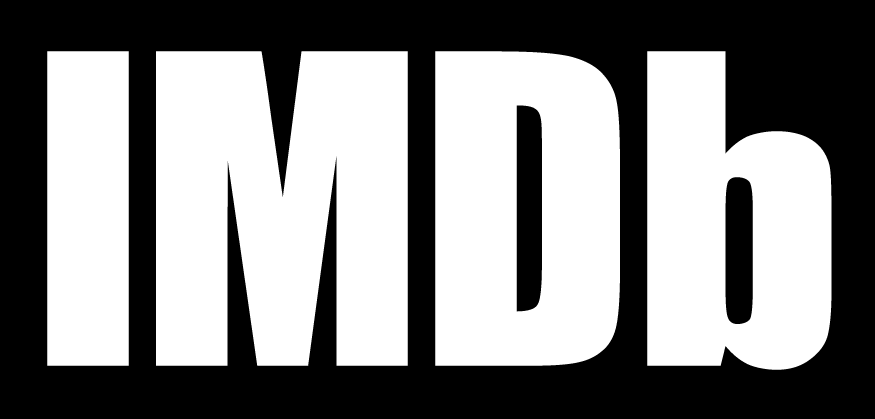

In [ ]:
#Loading mask for wordcloud
imdb_mask = Image.open('/content/drive/MyDrive/CS412/course_project/imdb/IMDb_Logo.png')
imdb_mask = np.array(imdb_mask)
imdb_mask[:,:,3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
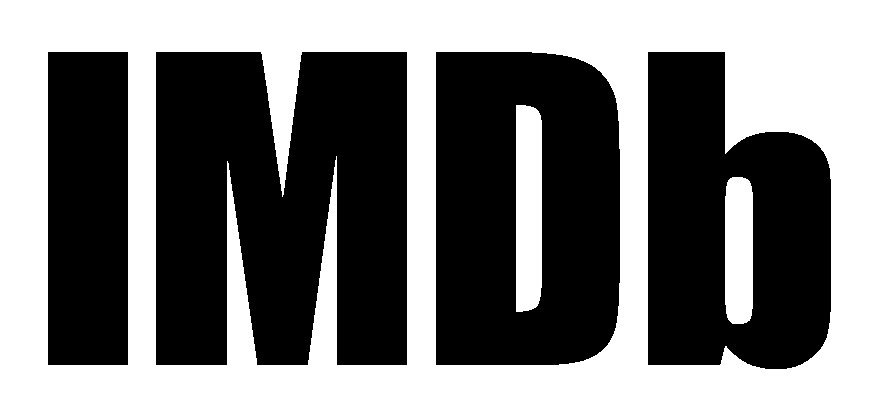

In [ ]:
#Converting mask to array, inverting mask
imdb_mask = np.array(imdb_mask)[:,:,3]
for i in range(imdb_mask.shape[0]):
  for j in range(imdb_mask.shape[1]):
    if imdb_mask[i,j] == 255:
      imdb_mask[i,j] = 0
    else:
      imdb_mask[i,j] = 255
imdb_mask

In [ ]:
imdb_mask.shape

(419, 875)

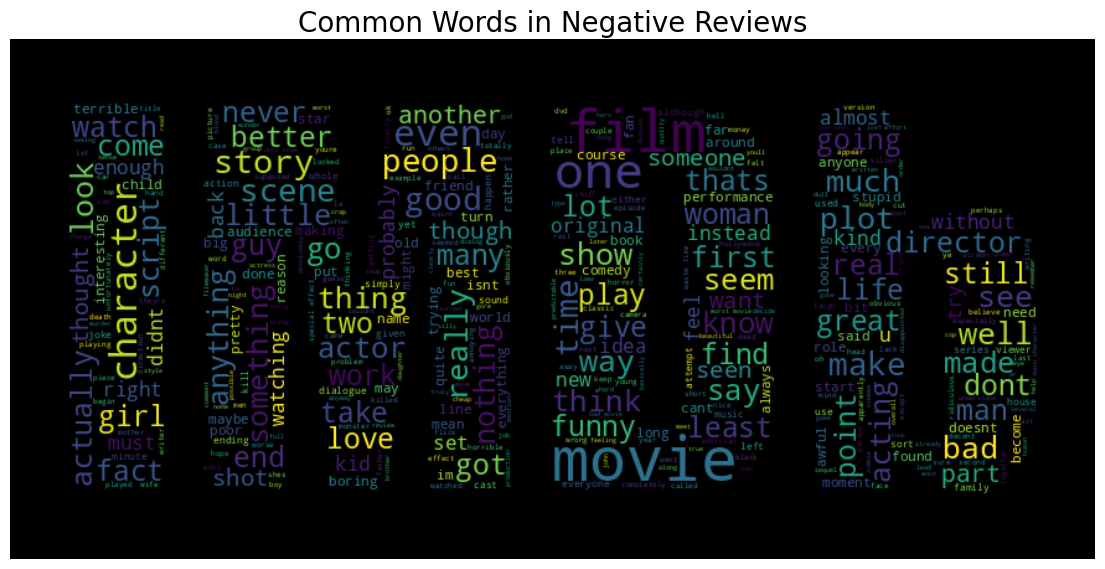

In [ ]:
text = ' '.join([review for review in neg_reviews['clean_review']])
plt.figure(figsize=(14,14), facecolor='None')
wordcloud = WordCloud(max_words=500, background_color="black", mask=imdb_mask, width=1024, height=1024).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Negative Reviews', fontsize = 20)
plt.show()

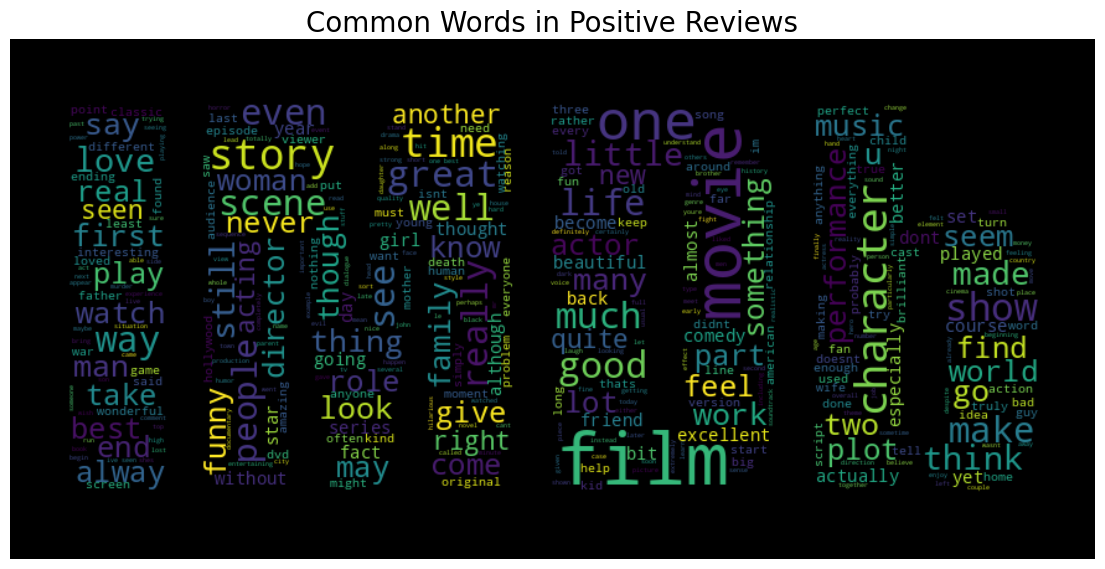

In [ ]:
text = ' '.join([review for review in pos_reviews['clean_review']])
plt.figure(figsize=(14,14), facecolor='None')
# wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
wordcloud = WordCloud(max_words=500, background_color="black", mask=imdb_mask, width=1024, height=1024).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Positive Reviews', fontsize = 20)
plt.show()

#**Let's run these experiments using tf-idf representation**

In [ ]:
#text representation: vectorizer is CountVectorizer() by default, TfidfVectorizer() alternatively
# vectorizer = CountVectorizer(max_features = 10000)
vectorizer = TfidfVectorizer(max_features = 10000)

# X = vectorizer.fit_transform(df['review'][0:2])
# X.toarray()

data = vectorizer.fit_transform(df['clean_review']).toarray()
data[0].shape

(10000,)

In [ ]:
pd.DataFrame(vectorizer.get_feature_names_out())

,0
0,007
1,010
2,10
3,100
4,1000
...,...
9995,zone
9996,zoo
9997,zoom
9998,zorro


In [ ]:
#splitting the dataset (80% train, 20% split)
x_train, x_test, y_train, y_test = train_test_split(data,df['sentiment'],test_size = 0.2, random_state = 1)
print(x_train.shape, x_test.shape)

(8000, 10000) (2000, 10000)


In [ ]:
# len([i for i in range (1,1000,20)])

50

In [ ]:
len([i for i in range (1,100,3)])

33

In [ ]:
#cross validation to find best k value for knn
#takes 19 minutes to compute
k_values = [i for i in range (1,100,3)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_train, y_train, cv=5)
    scores.append(np.mean(score))

#capturing the best k value
best_index = np.argmax(scores)
best_k = k_values[best_index]
best_k

97

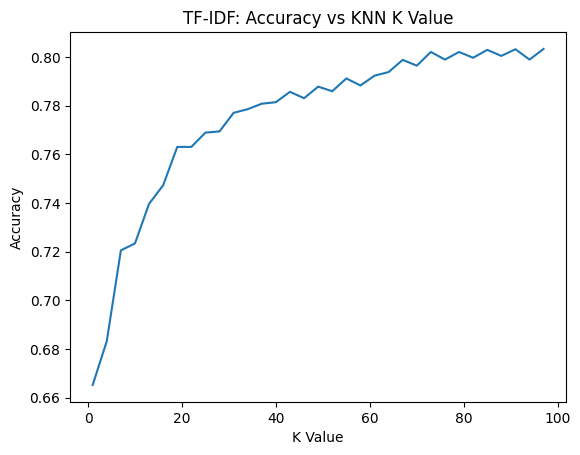

In [ ]:
plt.title('TF-IDF: Accuracy vs KNN K Value')
plt.plot(k_values, scores)
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
best_k = 97
models = []

models.append(('Logistic Regression',LogisticRegression(max_iter=1000)))
models.append(('Naive Bayes Classifier',MultinomialNB()))
models.append(('KNN Classifier',KNeighborsClassifier(n_neighbors=best_k))) #default n_neighbors is 5

In [ ]:
cms = []
for name, model in models:
    %time model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cms.append(confusion_matrix(y_test, y_pred))
    print(name ,'Accuracy Score : ',accuracy_score(y_test, y_pred))
    print(name ,'F1 Score : ',f1_score(y_test, y_pred))
    print('-----------------------------------------------------------------------')

CPU times: user 4.68 s, sys: 9.09 ms, total: 4.69 s
Wall time: 4.65 s
Logistic Regression Accuracy Score :  0.888
Logistic Regression F1 Score :  0.8905180840664711
-----------------------------------------------------------------------
CPU times: user 305 ms, sys: 0 ns, total: 305 ms
Wall time: 297 ms
Naive Bayes Classifier Accuracy Score :  0.864
Naive Bayes Classifier F1 Score :  0.8630412890231621
-----------------------------------------------------------------------
CPU times: user 66.5 ms, sys: 0 ns, total: 66.5 ms
Wall time: 66.7 ms
KNN Classifier Accuracy Score :  0.828
KNN Classifier F1 Score :  0.8246687054026505
-----------------------------------------------------------------------


In [ ]:
LR_cm = ConfusionMatrixDisplay(cms[0])
NB_cm = ConfusionMatrixDisplay(cms[1])
KNN_cm = ConfusionMatrixDisplay(cms[2])

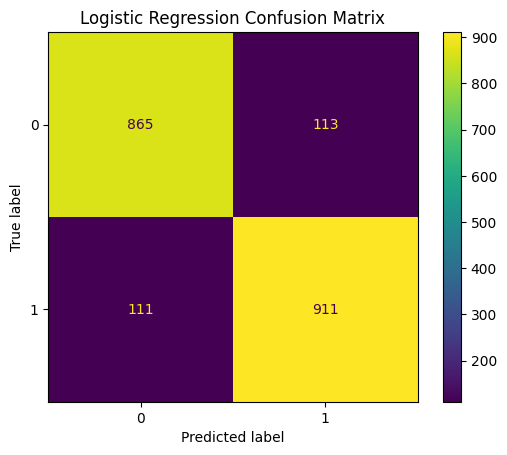

In [ ]:
LR_cm.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

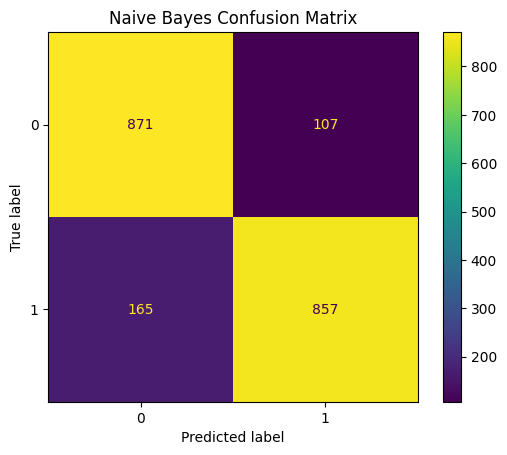

In [ ]:
NB_cm.plot()
plt.title('Naive Bayes Confusion Matrix')
plt.show()

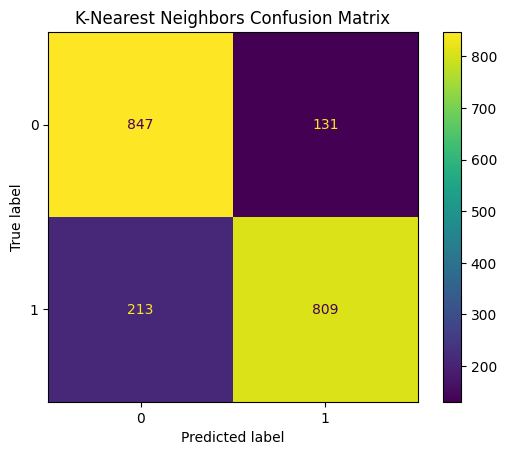

In [ ]:
KNN_cm.plot()
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()

In [ ]:
new_review = ['Thanks for uploading this amazing presentation. This video really helped clarify the topic', 'There goes 10 minutes of my life that I’ll never get back. This has to be the worst explanation I’ve ever suffered through. Truly Terrible.']
new_labels = [1,0]
for i in range(len(new_review)):
  new_review[i] = clean_text(new_review[i])
new_review

['thanks uploading amazing presentation video really helped clarify topic',
 'go 10 minute life i’ll never get back worst explanation i’ve ever suffered truly terrible']

In [ ]:
df1 = pd.DataFrame({"review": new_review, 'sentiment': new_labels, "clean_review": new_review})
df = pd.concat([df, df1], ignore_index=True)
# df.append(df1, ignore_index=True)
df.tail()

,review,sentiment,clean_review
9997,This movie is a bad movie. But after watching ...,0,movie bad movie watching endless series bad ho...
9998,This is a movie that was probably made to ente...,0,movie probably made entertain middle school ea...
9999,Smashing film about film-making. Shows the int...,1,smashing film filmmaking show intense strange ...
10000,thanks uploading amazing presentation video re...,1,thanks uploading amazing presentation video re...
10001,go 10 minute life i’ll never get back worst ex...,0,go 10 minute life i’ll never get back worst ex...


In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000)
new_data = vectorizer.fit_transform(df['clean_review']).toarray()
new_data.shape

(10002, 10000)

In [ ]:
#splitting the dataset (80% train, 20% split)
x_train, x_test, y_train, y_test = train_test_split(new_data[:-2],df['sentiment'][:-2],test_size = 0.2, random_state = 1)
print(x_train.shape, x_test.shape)

(8000, 10000) (2000, 10000)


In [ ]:
new_test = new_data[-2:]
new_test.shape

(2, 10000)

In [ ]:
new_y = df['sentiment'][-2:]

In [ ]:
cms = []
for name, model in models:
    %time model.fit(x_train, y_train)
    y_pred = model.predict(new_test)
    cms.append(confusion_matrix(new_y, y_pred))
    print(name ,'Accuracy Score : ',accuracy_score(new_y, y_pred))
    print(name ,'F1 Score : ',f1_score(new_y, y_pred))
    print('-----------------------------------------------------------------------')

CPU times: user 4.84 s, sys: 7.92 ms, total: 4.85 s
Wall time: 5.12 s
Logistic Regression Accuracy Score :  1.0
Logistic Regression F1 Score :  1.0
-----------------------------------------------------------------------
CPU times: user 359 ms, sys: 949 µs, total: 360 ms
Wall time: 392 ms
Naive Bayes Classifier Accuracy Score :  1.0
Naive Bayes Classifier F1 Score :  1.0
-----------------------------------------------------------------------
CPU times: user 70.6 ms, sys: 974 µs, total: 71.6 ms
Wall time: 74.1 ms
KNN Classifier Accuracy Score :  1.0
KNN Classifier F1 Score :  1.0
-----------------------------------------------------------------------


All 3 models correctly classified our two comments.